### Imports

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('fivethirtyeight')
plt.style.use('seaborn-darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import gzip
import json
import os
from urllib.request import urlopen

import re

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix,accuracy_score, plot_confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
np.random.seed(42)

In [3]:
votes_df = pd.read_csv('./Data/reviews.csv')
votes_df.head(1)

reviewerID        asin  reviewerName  \
0  A3UPYGJKZ0XTU4  0615391206  mirasreviews   

                                          reviewText  overall  \
0  There is no shortage of pop recipes available ...      4.0   

                                             summary  reviewDate  upvotes  \
0  Excels at Sweet Dessert Pops, but Falls Short ...  2013-05-05       26   

   total_votes     ratio  target  review_word_count  
0           27  0.962963       1                406

### NLP Pre-Processing

In [4]:
my_stopwords = stopwords.words('english')
print(my_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [5]:
# Removing words from my_stopwords list that might negatively impact sentiment analysis -- in case i want to explore that
my_stopwords.remove('out')
my_stopwords.remove('no')
my_stopwords.remove('not')

##### Function to clean data

In [6]:
# Function to clean up posts
# Adapted from : https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0

def clean_post(post):
    # Remove HTML 
    post = re.sub(r'\&\w*;', '', post)
    # lowercase
    post = post.lower()
    # Remove hyperlinks
    post = re.sub(r'https?:\/\/*\/\w*', '', post) 
    # Remove these characters/punctuations
    post = re.sub(r'[/(){}\[\]\|@?!,.;]', ' ', post)
    # More characters/digits to remove
    post = re.sub(r'[^0-9a-z #+_]', '', post)
    # Remove leading/trailing whitespace
    post = post.strip(' ')
    # Remove stopwords
    post = ' '.join(word for word in post.split() if word not in my_stopwords)
    # Remove whitespace
    post = re.sub(r'\s\s+', ' ', post)
    
    return post

In [7]:
text = 'QUICK SUMMARY:  This green-cleaning steam mop picks up floor smudges with ease, but it still takes time to pick-up dried-on floor debris.  Using it could be easier, too.This is my first steam mop.  I\'ve searched for a long time to find the easiest, most effective way to keep our white, ceramic tile clean.  After using this mop now for a week -- both before and after our New Year\'s Eve party -- I can say that while I like this mop, I don\'t love it.  Simple floor smudges are a snap to clean, but dried-on floor debris requires a lot of effort to remove, still.What I like:- No chemicals!- Picks up simple floor smudges very easily.- No streaking!- Dries very quickly on the floor.- Uses very, very little water (nice, if you\'re paying for distilled water, not tap).- Comes with a 2nd mop head, and they\'re machine washable.- So easy, my KIDS can use it!- No trigger to hold to get steam.- The mop handle stands-up vertically on its own.What I DON\'T like:- The cord is too short, maybe 20 feet long or so; I wish it were 10 feet longer.- I\'m 6\' 2", so the mop handle is too short to comfortably use; I still hunch over a little bit- If you don\'t use all the water you poured into the water tank, you won\'t know how much water to add to fill it to the top the next time you use it (and the instructions warn gravely about overfilling the water tank).- I still have to scrub to remove dried-on floor debris.Overall, I think we\'ll be able to mop more frequently than with the old-fashioned mop-and-bucket, and the results are better, too.  With a few improvements, I think I\'d love using this mop (as much as anyone can love any kind of mop).  Recommended!'
print(clean_post(text))

quick summary greencleaning steam mop picks floor smudges ease still takes time pickup driedon floor debris using could easier first steam mop ive searched long time find easiest effective way keep white ceramic tile clean using mop week new years eve party say like mop dont love simple floor smudges snap clean driedon floor debris requires lot effort remove still like no chemicals picks simple floor smudges easily no streaking dries quickly floor uses little water nice youre paying distilled water not tap comes 2nd mop head theyre machine washable easy kids use no trigger hold get steam mop handle standsup vertically dont like cord short maybe 20 feet long wish 10 feet longer im 6 2 mop handle short comfortably use still hunch little bit dont use water poured water tank wont know much water add fill top next time use instructions warn gravely overfilling water tank still scrub remove driedon floor debris overall think well able mop frequently oldfashioned mopandbucket results better i

##### Tokenization and Applying clean post function to dataset

In [8]:
# tokenizer = RegexpTokenizer(r'\w+')
# votes_df['review_tokens'] = votes_df['review_tokens'].map(tokenizer.tokenize)
# just going to use the built-in tokenizer within counte vectorizer and tfidf for now

votes_df['review_tokens'] = votes_df['reviewText'].map(clean_post)

votes_df.head(1)

reviewerID        asin  reviewerName  \
0  A3UPYGJKZ0XTU4  0615391206  mirasreviews   

                                          reviewText  overall  \
0  There is no shortage of pop recipes available ...      4.0   

                                             summary  reviewDate  upvotes  \
0  Excels at Sweet Dessert Pops, but Falls Short ...  2013-05-05       26   

   total_votes     ratio  target  review_word_count  \
0           27  0.962963       1                406   

                                       review_tokens  
0  no shortage pop recipes available free web pur...

**DUE TO THE EXTREMELY LARGE SIZE OF MY DATASET, IT IS NOT COMPUTATIONAL FEASIBLE FOR ME TO RUN ANY MODELS WITH THE WHOLE DATASET - AS YOU CAN SEE FROM THE MEMORY ERROR BELOW. AS SUCH I WILL BE USING A SAMPLE OF MY DATASET FROM HERE ON OUT**

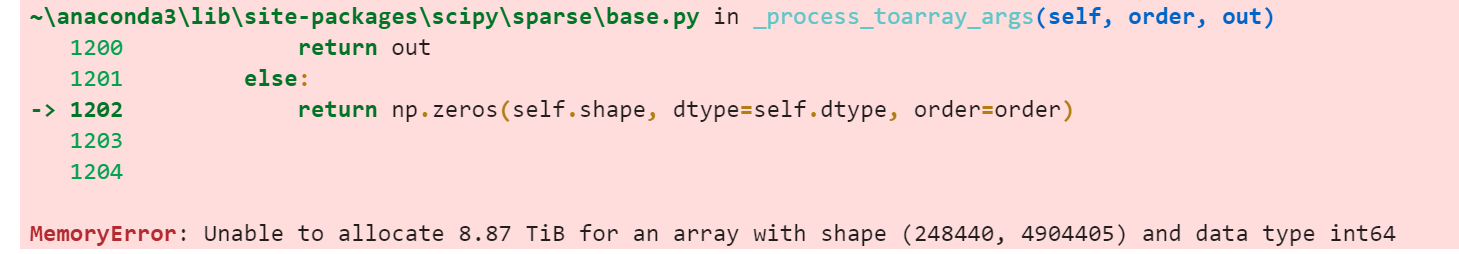

### Undersampling 

Bc dataset is imbalanced we will need to balance it. Going to undersample majority class, bc dataset is already huge enough, so would help in also reducing the size of the dataset.  
Undersampling can be dangerous though bc such a large amount of data is discarded, we can lose some valuable info that might negatively impact the classification performance.

In [11]:
min_count = len(votes_df[votes_df['target'] == 0])//2
maj_class = votes_df['target'] == 1

min_class_df = votes_df[votes_df['target'] == 0].sample(n=min_count, random_state=42)

undersamp_votes = votes_df[maj_class].sample(n=min_count, random_state=42)

undersamp_votes = pd.concat([undersamp_votes, min_class_df], axis=0, ignore_index=True)

In [12]:
undersamp_votes.shape

(57878, 13)

In [13]:
undersamp_votes['target'].value_counts()

0    28939
1    28939
Name: target, dtype: int64

In [14]:
undersamp_votes['overall'].value_counts(normalize=True).sort_index()

1.0    0.103511
2.0    0.074173
3.0    0.116400
4.0    0.189105
5.0    0.516811
Name: overall, dtype: float64

In [15]:
votes_df['overall'].value_counts(normalize=True).sort_index()

1.0    0.080647
2.0    0.060063
3.0    0.098040
4.0    0.192437
5.0    0.568813
Name: overall, dtype: float64

Distribution of star ratings in undersampled dataset are very similar to original dataset.

##### Saving undersamp_votes dataset

In [ ]:
undersamp_votes.to_csv('Data/undersampled_reviews.csv', index=False)

### Count Vectorizer

In [16]:
cv = CountVectorizer(stop_words='english',
                    ngram_range=(1,1),
                    max_df=.98,
                    min_df=100,
                    max_features=10_000)

cv_vocab = cv.fit_transform(undersamp_votes['review_tokens'])

cv_df = pd.DataFrame(
    cv_vocab.todense(),
    columns= cv.get_feature_names())

In [17]:
# Top 15 words in corpus
cv_df.sum().sort_values(ascending=False).head(15)

use        30676
like       26369
great      19374
good       18563
time       16435
coffee     15460
dont       15410
water      14658
really     14584
easy       14296
used       13793
little     13085
make       12638
im         11616
product    11557
dtype: int64

##### BiGRAMS

In [18]:
cv_bigrams = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=10_000)

bigrams_cv = cv_bigrams.fit_transform(undersamp_votes['review_tokens'])
bigrams_df = pd.DataFrame(bigrams_cv.todense(), columns=cv_bigrams.get_feature_names())

bigrams_df.sum().sort_values(ascending=False).head(15)

stainless steel     2609
easy clean          2585
easy use            2242
works great         1689
coffee maker        1649
highly recommend    1599
ive used            1421
dont know           1371
make sure           1331
long time           1287
ice cream           1272
im sure             1233
really like         1193
years ago           1144
cast iron           1131
dtype: int64

In [19]:
# Top 15 bigrams for 'helpful' reviews
cv_bigrams = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=10_000)

bigrams_cv = cv_bigrams.fit_transform(undersamp_votes[undersamp_votes['target']==1]['review_tokens'])
bigrams_df = pd.DataFrame(bigrams_cv.todense(), columns=cv_bigrams.get_feature_names())

bigrams_df.sum().sort_values(ascending=False).head(15)

easy clean          1568
stainless steel     1461
easy use            1296
highly recommend    1040
works great          952
ive used             862
coffee maker         809
make sure            808
long time            733
ice cream            731
cast iron            695
years ago            682
really like          671
dont know            657
im sure              564
dtype: int64

In [20]:
# Top 15 bigrams for 'unhelpful' reviews
cv_bigrams = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=10_000)

bigrams_cv = cv_bigrams.fit_transform(undersamp_votes[undersamp_votes['target']==0]['review_tokens'])
bigrams_df = pd.DataFrame(bigrams_cv.todense(), columns=cv_bigrams.get_feature_names())

bigrams_df.sum().sort_values(ascending=False).head(15)

stainless steel     1148
easy clean          1017
easy use             946
coffee maker         840
works great          737
dont know            714
im sure              669
highly recommend     559
ive used             559
long time            554
ice cream            541
cup coffee           533
make sure            523
really like          522
french press         481
dtype: int64

##### TriGRAMS

In [28]:
cv_trigrams = CountVectorizer(ngram_range=(3, 3), stop_words='english', max_features=10_000)

trigrams_cv = cv_trigrams.fit_transform(undersamp_votes['review_tokens'])
trigrams_df = pd.DataFrame(trigrams_cv.todense(), columns=cv_trigrams.get_feature_names())

y = trigrams_df.sum().sort_values(ascending=False).head(15)

In [29]:
cv_trigrams = CountVectorizer(ngram_range=(3, 3), stop_words='english', max_features=10_000)

trigrams_cv = cv_trigrams.fit_transform(undersamp_votes[undersamp_votes['target']==0]['review_tokens'])
trigrams_df = pd.DataFrame(trigrams_cv.todense(), columns=cv_trigrams.get_feature_names())

z = trigrams_df.sum().sort_values(ascending=False).head(15)

In [30]:
cv_trigrams = CountVectorizer(ngram_range=(3, 3), stop_words='english', max_features=10_000)

trigrams_cv = cv_trigrams.fit_transform(undersamp_votes[undersamp_votes['target']==1]['review_tokens'])
trigrams_df = pd.DataFrame(trigrams_cv.todense(), columns=cv_trigrams.get_feature_names())

x = trigrams_df.sum().sort_values(ascending=False).head(15)

In [76]:
ziplist = zip(z.index,y.index,x.index)

r = tuple(ziplist)

dat = list(r)

dat_df = pd.DataFrame(dat, columns =['tri-total', 'tri-helpful', 'tri-unhelpful'])

In [77]:
dat_df

tri-total               tri-helpful  \
0       memory foam mattress      memory foam mattress   
1           dont waste money             easy use easy   
2             oxo good grips            oxo good grips   
3              easy use easy            use easy clean   
4             use easy clean          dont waste money   
5        french press coffee          works like charm   
6             easy use clean           ice cream maker   
7            ice cream maker            easy use clean   
8           works like charm  highly recommend product   
9          drip coffee maker            love love love   
10           good cup coffee       french press coffee   
11          great cup coffee          bought years ago   
12  highly recommend product           good cup coffee   
13         ill update review          great cup coffee   
14           im giving stars         im happy purchase   

               tri-unhelpful  
0              easy use easy  
1             use easy clean  
2           works like charm  
3       memory foam mattress  
4   highly recommend product  
5            ice cream maker  
6             love love love  
7             oxo good grips  
8             easy use clean  
9           bought years ago  
10          dont waste money  
11         im happy purchase  
12          super easy clean  
13           good cup coffee  
14           thing dont like

There doesn't seem to be much of a distinction between the top bigrams and trigrams when grouped by helpfullness. This might be due to the fact that thevcorpus includes reviews from different product categories. So it would make sense to separate these categories before running the count vectorizers and tfidf. Since we don't have the actual categories of the reviews in this dataset, we can use something like LDA analysis to do topic modeling. Then we can group by distinct categories to see whether it creates some separation between the target variables.

### Set up X and y for Modeling

In [78]:
X = undersamp_votes['review_tokens']
y = undersamp_votes['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [80]:
cv = CountVectorizer(stop_words='english',
                    ngram_range=(1,2),
                    max_df=.98,
                    min_df=100,
                    max_features=10_000)

X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

##### Baseline Accuracy

In [199]:
y_test.mean()

0.5

##### Setting up LSA plot using Truncated SVD for dimensionality reduction

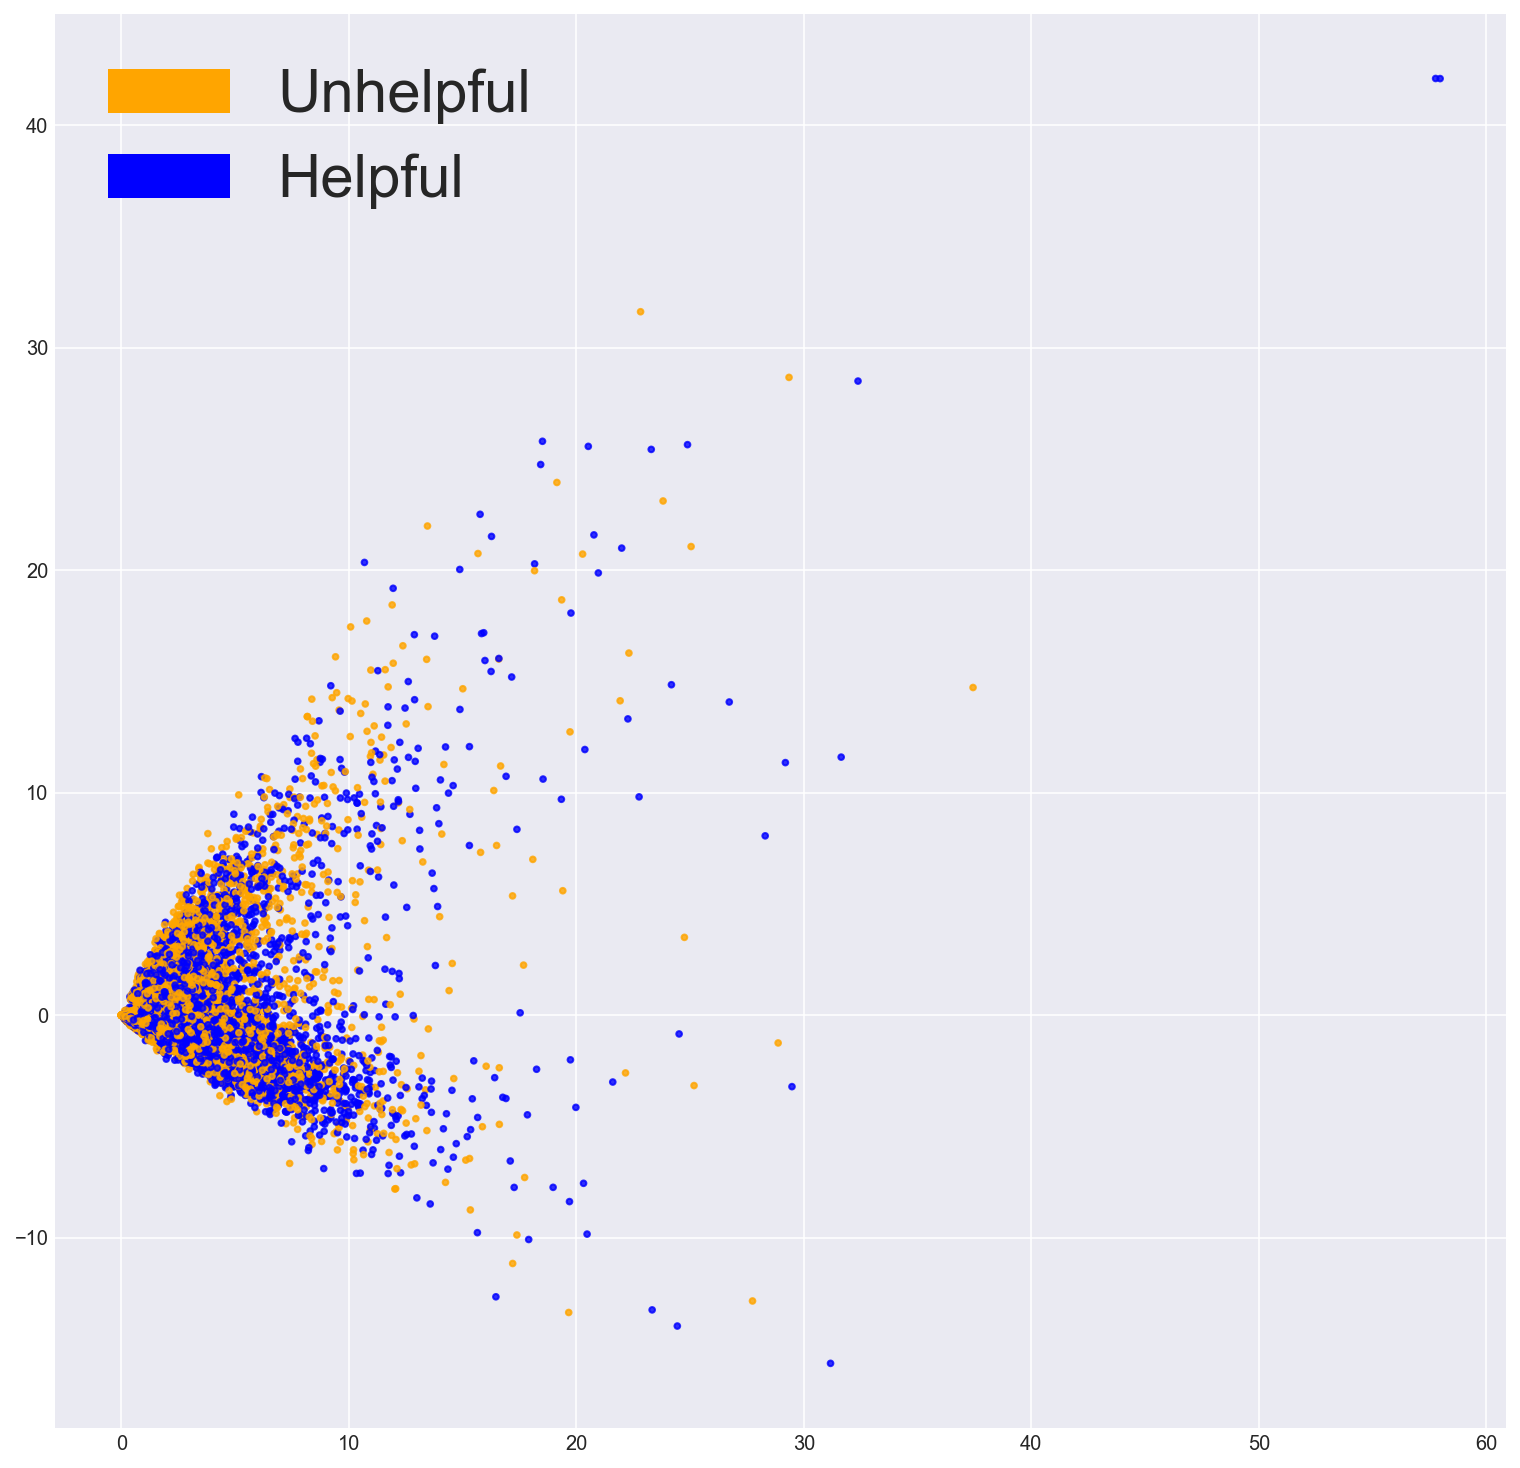

In [82]:
# Adapted from: https://www.kdnuggets.com/2019/01/solve-90-nlp-problems-step-by-step-guide.html#comments

from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Unhelpful')
            green_patch = mpatches.Patch(color='blue', label='Helpful')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})




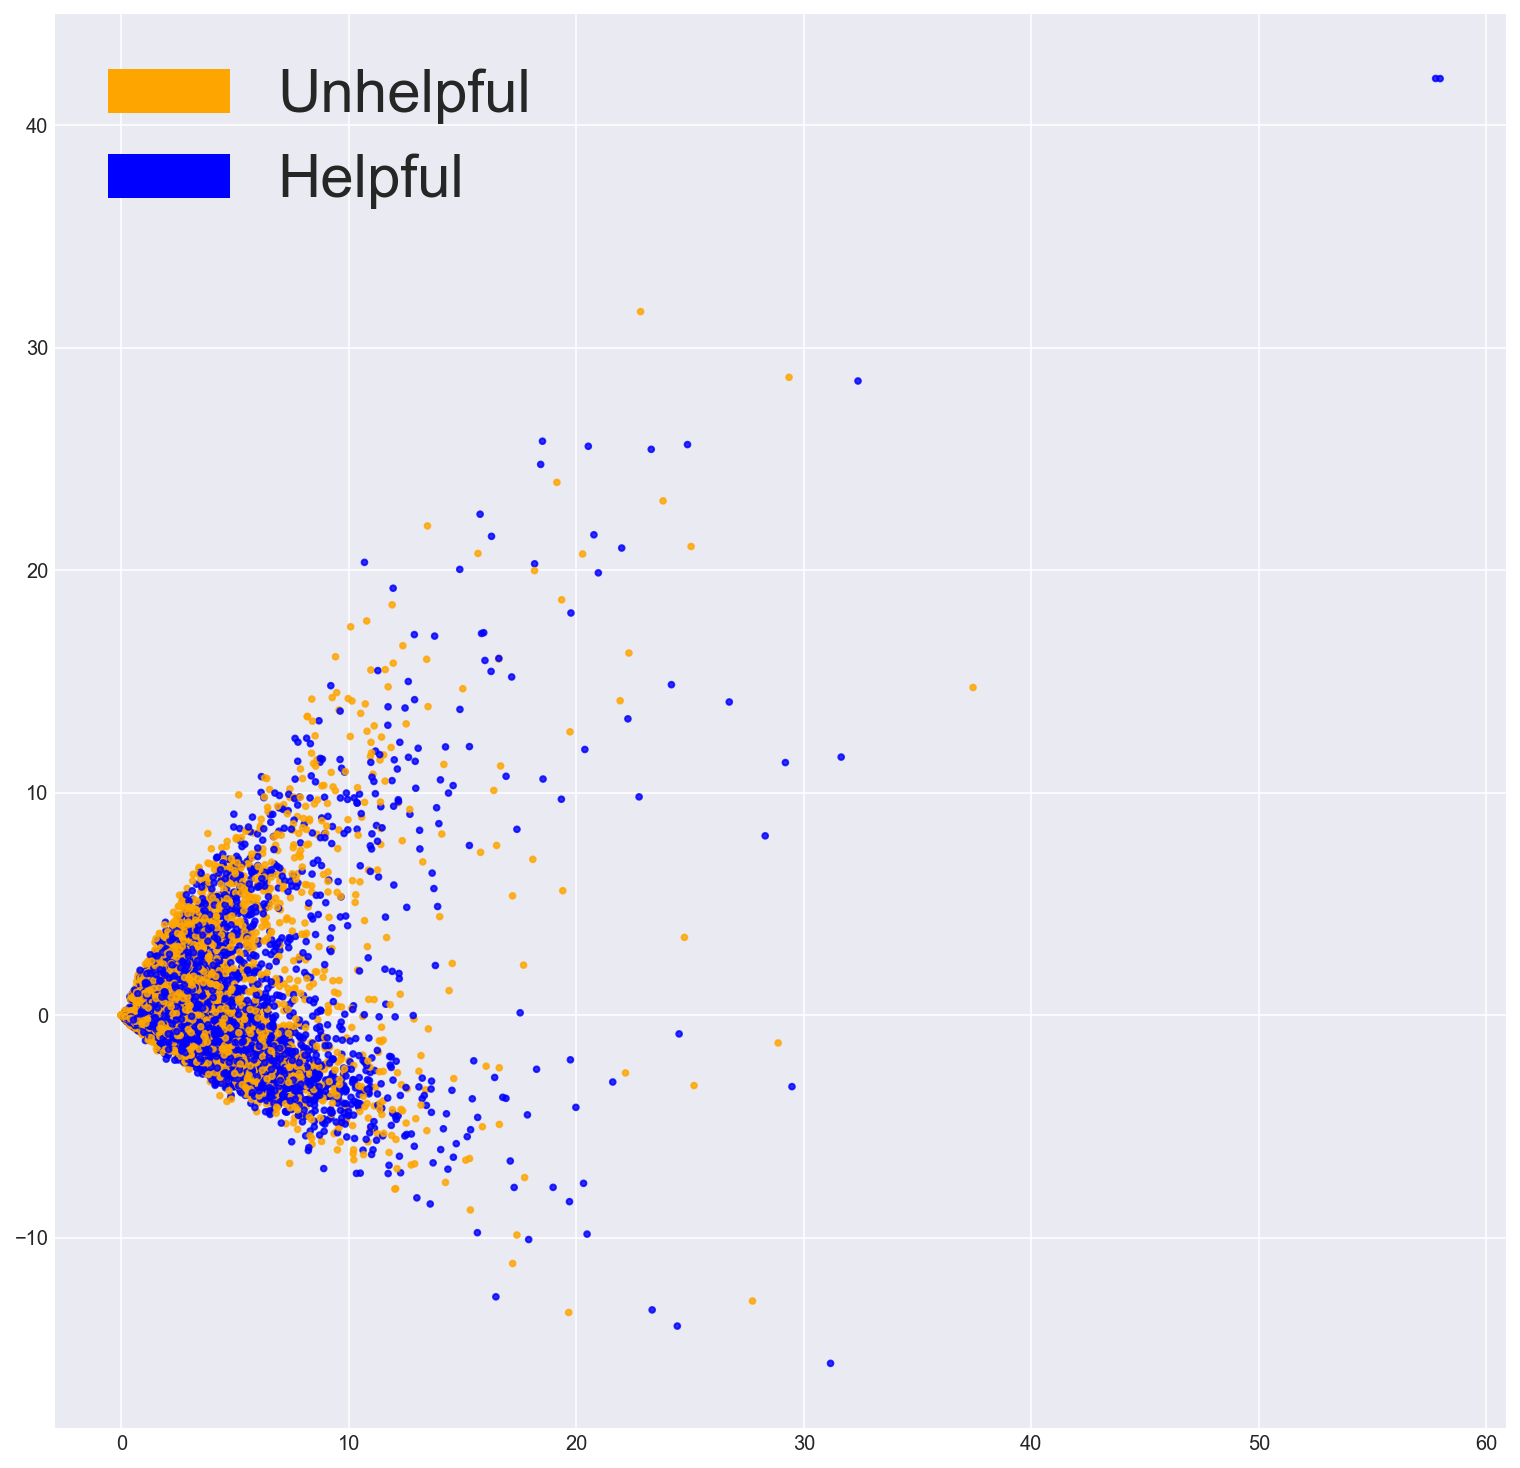

In [178]:
fig = plt.figure(figsize=(13, 13))          
plot_LSA(X_train_cv, y_train)
# plt.show()
plt.savefig('Images/cv_lsa.png')

Not much separation between the two variables. Important to note these points are not interpretable, only representation of two dimensions i specified.

In [89]:
%%time

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=8, 
                                max_iter=10, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=42,
                               verbose=1)

model = lda.fit_transform(X_train_cv)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Wall time: 3min 26s


##### LDA Topic Modeling

In [90]:
def display_topics(model, feature_names, top_words):
    for topic_idx, topic in enumerate(lda.components_):
        print("Topic:" topic_idx)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print(" ")

In [92]:
feature_names = cv.get_feature_names()
top_words = 50
display_topics(lda, feature_names, top_words)

Topic 0:
set, knife, use, steel, knives, stainless, pot, rice, dishwasher, handle, lid, cooker, cooking, like, stainless steel, used, pans, great, sharp, kitchen, handles, cook, food, love, clean, cookware, years, good, easy, safe, pressure, blade, hand, nonstick, ive, lids, pots, using, edge, nice, slow, dont, really, perfect, cut, metal, cutting, pan, pasta, popcorn


Topic 1:
pan, oven, use, bread, iron, cooking, oil, time, cook, baking, toaster, used, heat, grill, pans, great, like, hot, eggs, make, board, food, nonstick, cast, using, love, clean, cake, little, minutes, egg, cast iron, easy, pizza, cooked, good, chicken, meat, perfect, toast, steamer, steam, skillet, microwave, water, evenly, temperature, bake, makes, dough


Topic 2:
unit, air, amazon, time, new, product, years, fan, like, bought, im, reviews, room, dont, 34, months, buy, old, got, use, year, used, review, know, didnt, high, box, model, good, thing, replacement, problem, going, update, day, work, setting, ive, low

##### LSA plot of LDA Topic Modeling

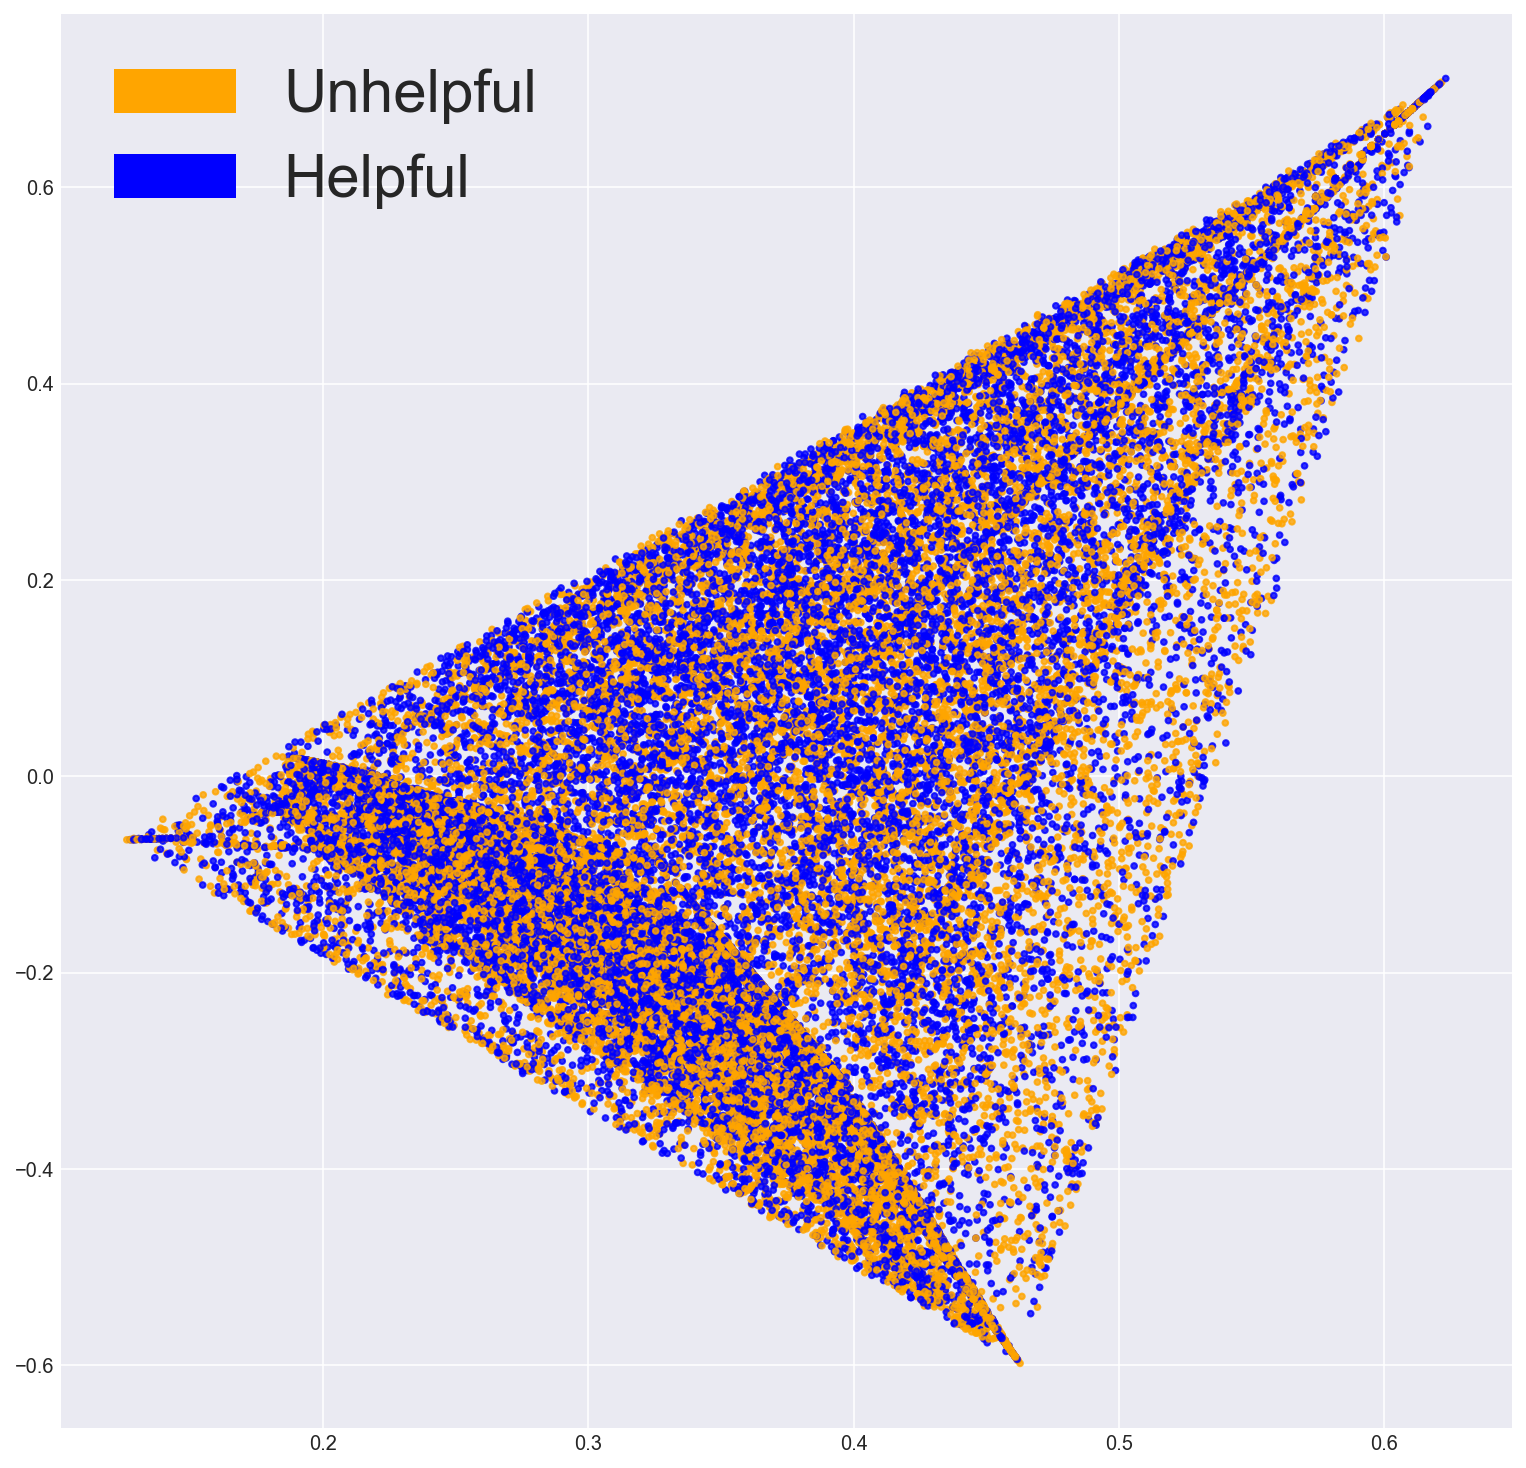

<Figure size 432x288 with 0 Axes>

In [168]:
fig = plt.figure(figsize=(13, 13))          
plot_LSA(model, y_train)
plt.show()
plt.savefig('Images/cv_lsa_lda.png')

Not very good separation at all. Worse than original without topics.

In [98]:
%%time
logreg = LogisticRegression(solver='liblinear')

logreg.fit(X_train_cv, y_train)

Wall time: 3.2 s


LogisticRegression(solver='liblinear')

In [101]:
logreg.score(X_train_cv, y_train)

0.6607537781054184

In [102]:
logreg.score(X_test_cv, y_test)

0.5790601243953006

##### LogReg with topic modeling

In [103]:
%%time
logreg = LogisticRegression(solver='liblinear')

logreg.fit(model, y_train)

Wall time: 104 ms


LogisticRegression(solver='liblinear')

In [104]:
logreg.score(model, y_train)

0.5427570954662735

In [107]:
%%time
mnb = MultinomialNB()

mnb.fit(X_train_cv, y_train)
mnb.score(X_train_cv, y_train), mnb.score(X_test_cv, y_test)

Wall time: 46 ms


(0.615623848138592, 0.591845196959226)

In [109]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

dtc = DecisionTreeClassifier()
dtc.fit(X_train_cv,y_train)
print(dtc.score(X_train_cv, y_train), dtc.score(X_test_cv, y_test))
print('')

bc = BaggingClassifier()
bc.fit(X_train_cv,y_train)
print(bc.score(X_train_cv, y_train), bc.score(X_test_cv, y_test))
print('')

rfc = RandomForestClassifier()
rfc.fit(X_train_cv,y_train)
print(rfc.score(X_train_cv, y_train), rfc.score(X_test_cv, y_test))
print('')

adc = AdaBoostClassifier()
adc.fit(X_train_cv,y_train)
print(adc.score(X_train_cv, y_train), adc.score(X_test_cv, y_test))
print('')

svc = SVC()
svc.fit(X_train_cv,y_train)
print(svc.score(X_train_cv, y_train), svc.score(X_test_cv, y_test))
print('')

0.9999308883155179 0.5348306841741535

0.9839660892001474 0.5521769177608846

0.9999308883155179 0.5903248099516241

0.5910661629192776 0.5821008984105045

0.7884491338002212 0.6011748445058742

Wall time: 53min 28s


In [147]:
y_preds_logreg_cv = logreg.predict(X_test_cv)
plot_confusion_matrix(logreg, X_test_cv, y_test)

ValueError: X has 3297 features per sample; expecting 3168

##### Lemmatizer

In [138]:
wl = WordNetLemmatizer()
# post = (wl.lemmatize(p) for p in post.split())
def lemmatizer(post):
    lem_list = []
    for each in post.split():
        lem = wl.lemmatize(each)
        lem_list.append(lem)

    return ' '.join(lem_list) # unpacks the lem_list from a list to string

In [139]:
undersamp_votes['lemma_tokens'] = undersamp_votes['review_tokens'].map(lemmatizer)
undersamp_votes.head(1)

reviewerID        asin      reviewerName  \
0  A1G2PJDZG31P79  B00D0WBGM6  Michael Desimone   

                                          reviewText  overall  \
0  This mat is very easy to clean, high quality a...      5.0   

                         summary  reviewDate  upvotes  total_votes     ratio  \
0  Very nice silicone baking mat  2013-09-23       10           11  0.909091   

   target  review_word_count  \
0       1                 38   

                                       review_tokens  \
0  mat easy clean high quality put dishwasher eas...   

                                        lemma_tokens  
0  mat easy clean high quality put dishwasher eas...

In [129]:
wl.lemmatize('leadership')

'leadership'

### TFIDF

In [140]:
X = undersamp_votes['lemma_tokens']
y = undersamp_votes['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [141]:
tfidf = TfidfVectorizer(stop_words='english',
                    ngram_range=(1,2),
                    max_df=.98,
                    min_df=100,
                    max_features=10_000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [187]:
# dir(tfidf)

##### Top words in TFIDF Vectorizer

In [177]:
pd.Series(tfidf.idf_, index=tfidf.get_feature_names()).sort_values(ascending=True).head(15)

use        2.075027
like       2.168199
great      2.355914
time       2.409341
good       2.428765
make       2.456153
work       2.463393
dont       2.605621
really     2.671913
easy       2.673754
used       2.682637
product    2.756698
little     2.782655
thing      2.826759
love       2.832501
dtype: float64

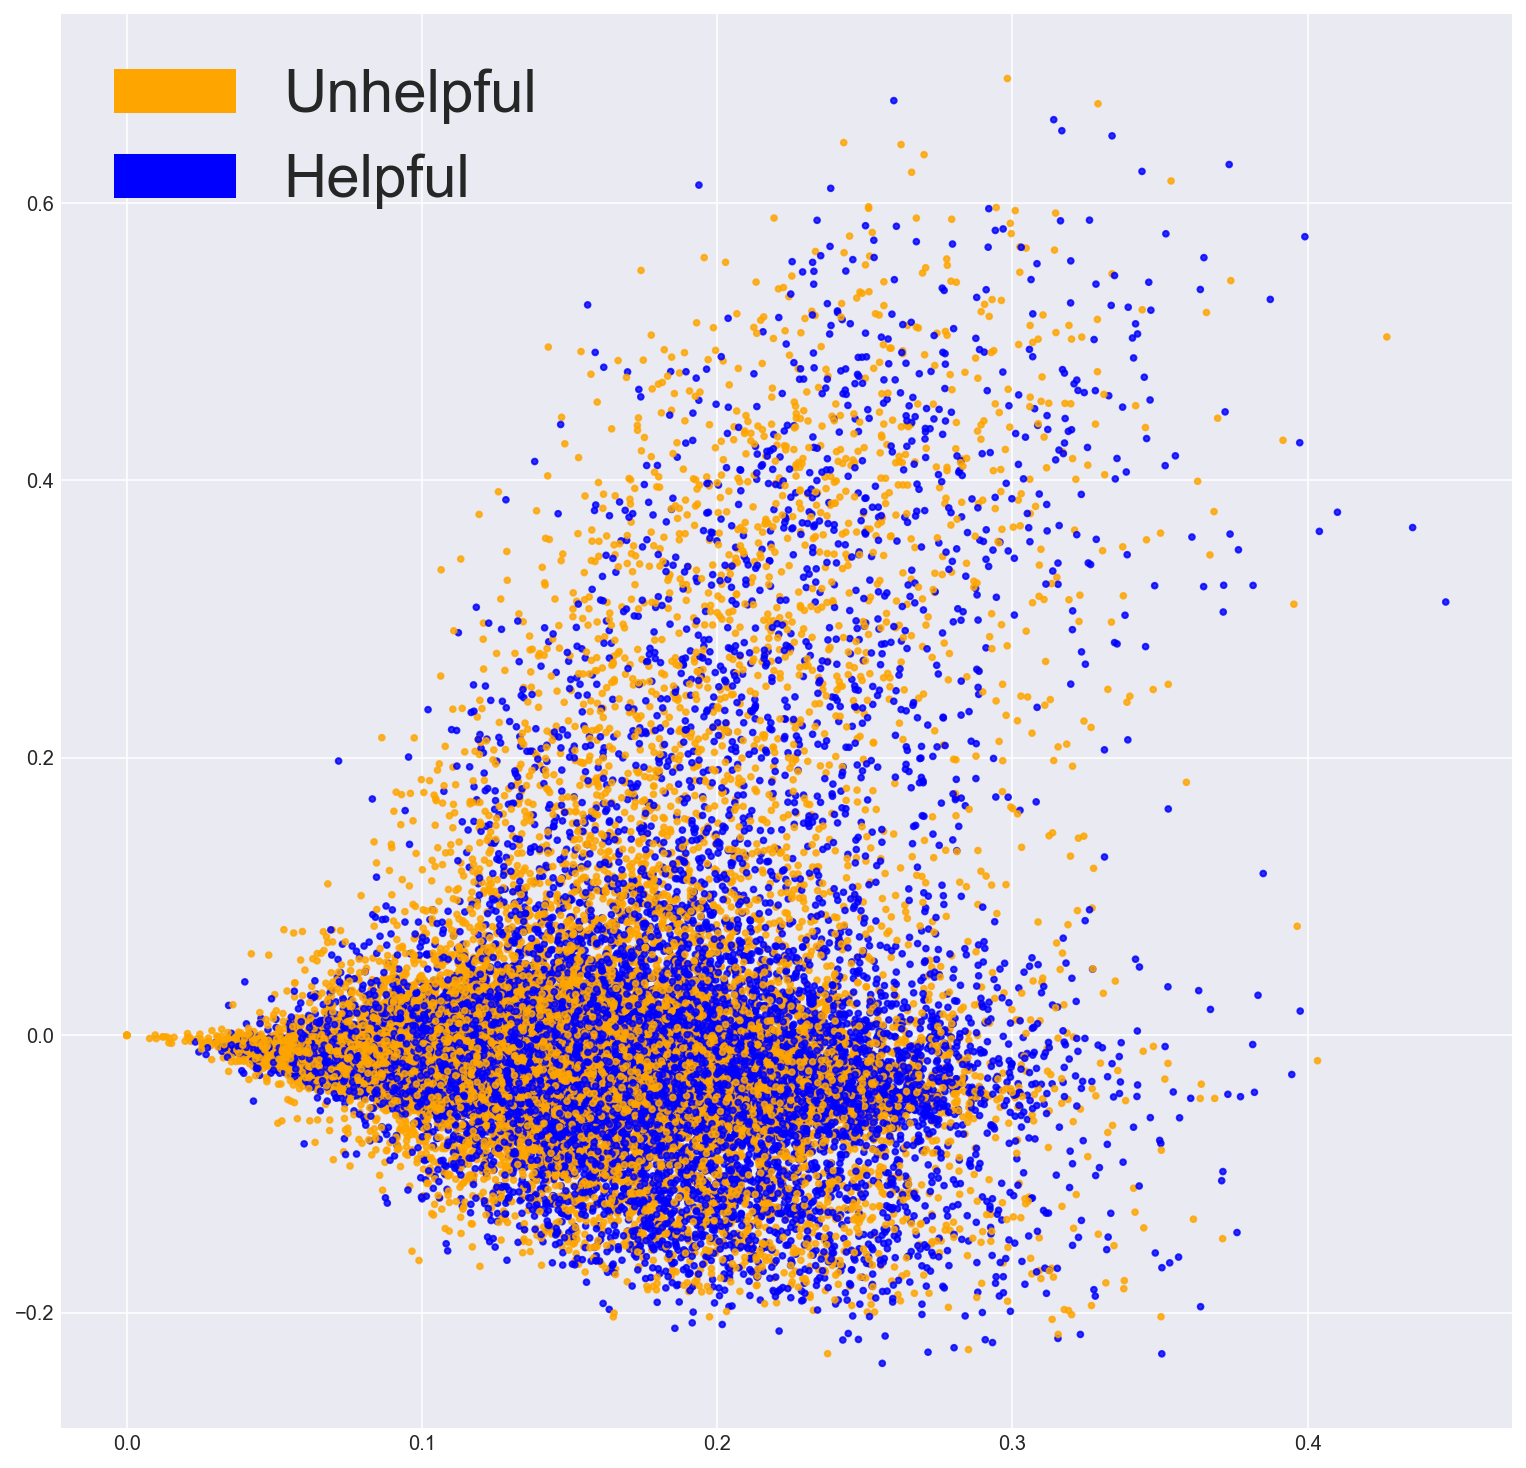

<Figure size 432x288 with 0 Axes>

In [167]:
fig = plt.figure(figsize=(13, 13))          
plot_LSA(X_train_tfidf, y_train)
plt.show()
plt.savefig('Images/tfidf_lsa.png')

Separation not great

In [143]:
logreg = LogisticRegression(solver='liblinear')

logreg.fit(X_train_tfidf, y_train)
logreg.score(X_train_tfidf, y_train), logreg.score(X_test_tfidf, y_test)

(0.6615600810910431, 0.5993780234968901)

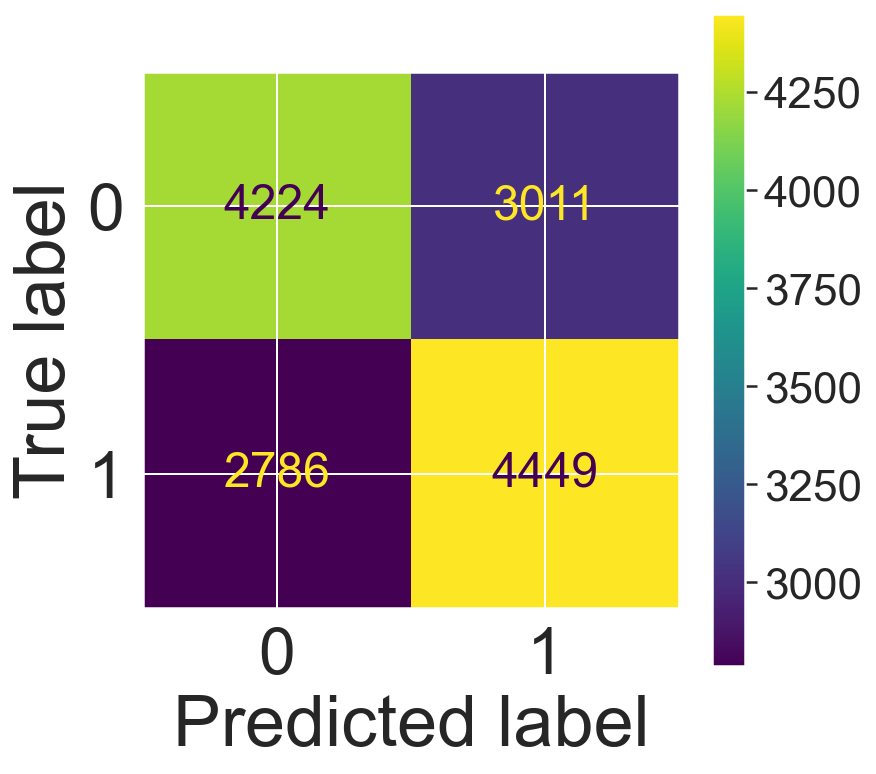

In [196]:
y_preds_logreg_tfidf = logreg.predict(X_test_tfidf)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=2,)
plot_confusion_matrix(logreg, X_test_tfidf, y_test, ax=ax);

plt.savefig('Images/tfidf_logreg_matrix.png')

In [150]:
print(classification_report(y_test, y_preds_logreg_tfidf))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59      7235
           1       0.60      0.61      0.61      7235

    accuracy                           0.60     14470
   macro avg       0.60      0.60      0.60     14470
weighted avg       0.60      0.60      0.60     14470



In [144]:
mnb = MultinomialNB()

mnb.fit(X_train_tfidf, y_train)
mnb.score(X_train_tfidf, y_train), mnb.score(X_test_tfidf, y_test)

(0.6225810910431256, 0.5896337249481686)

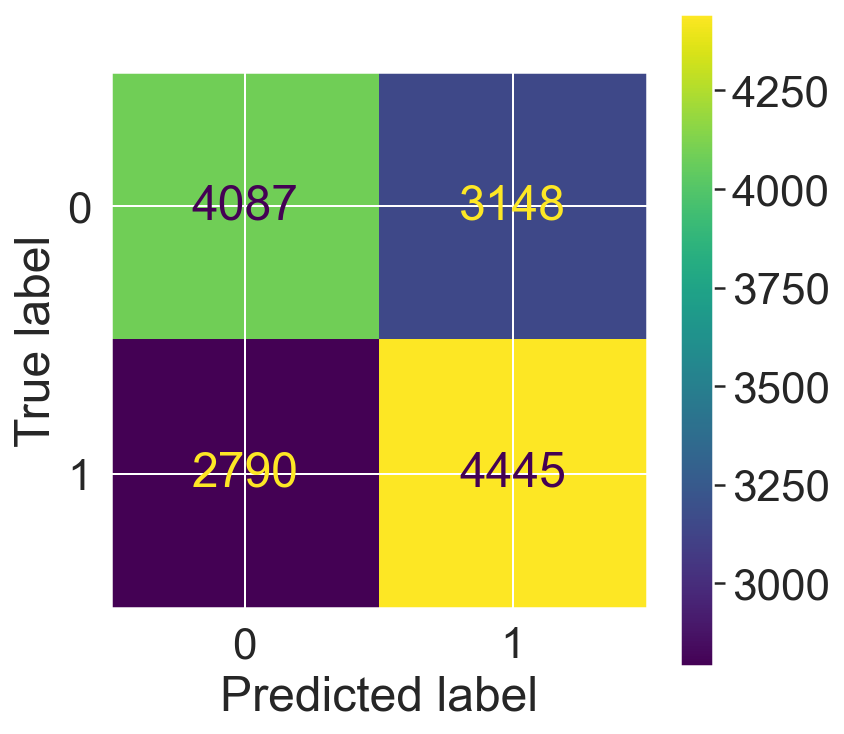

In [198]:
y_preds_mnb_tfidf = mnb.predict(X_test_tfidf)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=2,)
plot_confusion_matrix(mnb, X_test_tfidf, y_test, ax=ax);

plt.savefig('Images/tfidf_mnb_matrix.png')

In [151]:
print(classification_report(y_test, y_preds_mnb_tfidf))

              precision    recall  f1-score   support

           0       0.59      0.56      0.58      7235
           1       0.59      0.61      0.60      7235

    accuracy                           0.59     14470
   macro avg       0.59      0.59      0.59     14470
weighted avg       0.59      0.59      0.59     14470



### Word2Vec